In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import streamlit as st
from datetime import datetime, timedelta

# Load the data
transactional_data_1 = pd.read_csv(r"C:\Users\H P\Downloads\Data science\Transactional_data_retail_01.csv")
transactional_data_2 = pd.read_csv(r"C:\Users\H P\Downloads\Data science\Transactional_data_retail_02.csv",encoding='latin1')
customer_data = pd.read_csv(r"C:\Users\H P\Downloads\Data science\CustomerDemographics.csv",encoding='latin1')
product_info = pd.read_csv(r"C:\Users\H P\Downloads\Data science\ProductInfo.csv",encoding='latin1')

In [22]:
transactional_data = pd.concat([transactional_data_1, transactional_data_2], ignore_index=True)

# Remove leading/trailing spaces from column names
transactional_data.columns = transactional_data.columns.str.strip()
product_info.columns = product_info.columns.str.strip()

# Fix column names with 'ï»¿' character in both datasets
transactional_data.rename(columns=lambda x: x.replace('ï»¿', ''), inplace=True)
product_info.rename(columns=lambda x: x.replace('ï»¿', ''), inplace=True)

# Check column names to confirm the fix
print(transactional_data.columns)  # To check column names in transactional_data
print(product_info.columns)        # To check column names in product_info

# Create the 'Revenue' column
transactional_data['Revenue'] = transactional_data['Quantity'] * transactional_data['Price']

# Merge with product_info on 'StockCode' to get the product descriptions
if 'StockCode' in product_info.columns and 'StockCode' in transactional_data.columns:
    complete_data = transactional_data.merge(product_info[['StockCode', 'Description']], on='StockCode', how='left')
else:
    print("StockCode column is missing in one of the datasets.")

# Display the first few rows of the merged data
print(complete_data.head())


Index(['Invoice', 'StockCode', 'Quantity', 'Price', 'Customer ID',
       'InvoiceDate', 'Invoice'],
      dtype='object')
Index(['StockCode', 'Description'], dtype='object')
  Invoice StockCode  Quantity  Price  Customer ID       InvoiceDate Invoice  \
0  489434     85048        12   6.95      13085.0  01 December 2021     NaN   
1  489434    79323P        12   6.75      13085.0  01 December 2021     NaN   
2  489434    79323P        12   6.75      13085.0  01 December 2021     NaN   
3  489434    79323P        12   6.75      13085.0  01 December 2021     NaN   
4  489434    79323W        12   6.75      13085.0  01 December 2021     NaN   

   Revenue                          Description  
0     83.4  15CM CHRISTMAS GLASS BALL 20 LIGHTS  
1     81.0                   PINK CHERRY LIGHTS  
2     81.0               Unsaleable, destroyed.  
3     81.0                                  NaN  
4     81.0                  WHITE CHERRY LIGHTS  


In [23]:
print(complete_data.columns)

print("Missing Customer ID values:", complete_data['Customer ID'].isnull().sum())

complete_data = complete_data.dropna(subset=['Customer ID'])

complete_data.loc[:, 'Customer ID'] = complete_data['Customer ID'].astype(str).str.strip()

# Remove duplicate 'InvoiceNo' column if it exists
if 'InvoiceNo' in complete_data.columns and complete_data.columns.duplicated().any():
    complete_data = complete_data.loc[:, ~complete_data.columns.duplicated()]

print(complete_data.columns)

customer_summary = complete_data.groupby('Customer ID').agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'InvoiceNo': 'nunique'
}).rename(columns={'InvoiceNo': 'Unique Transactions'})

print(customer_summary.head())

item_summary.to_csv("item_summary.csv", index=False)
customer_summary.to_csv("customer_summary.csv", index=False)
print("\nSummaries have been saved to CSV files.")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Quantity', y='Description', data=top_10_items)
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.show()


Index(['Invoice', 'StockCode', 'Quantity', 'Price', 'Customer ID',
       'InvoiceDate', 'Invoice', 'Revenue', 'Description'],
      dtype='object')
Missing Customer ID values: 456094
Index(['Invoice', 'StockCode', 'Quantity', 'Price', 'Customer ID',
       'InvoiceDate', 'Invoice', 'Revenue', 'Description'],
      dtype='object')


KeyError: "Column(s) ['InvoiceNo'] do not exist"

In [ ]:
top_10_quantity = item_summary.sort_values(by='Quantity', ascending=False).head(10)
print("\nTop 10 Stock Codes by Quantity Sold:")
print(top_10_quantity)

# Top 10 High Revenue Products
top_10_revenue = item_summary.sort_values(by='Revenue', ascending=False).head(10)
print("\nTop 10 Products by Revenue:")
print(top_10_revenue)


Top 10 Stock Codes by Quantity Sold:
     StockCode                         Description  Quantity    Revenue
4820     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS    108545   24898.22
5696    85123A  WHITE HANGING HEART T-LIGHT HOLDER     96066  253720.02
5693    85123A                         21733 mixed     96066  253720.02
5695    85123A  CREAM HANGING HEART T-LIGHT HOLDER     96066  253720.02
5697    85123A         wrongly marked carton 22804     96066  253720.02
5694    85123A                                   ?     96066  253720.02
5662    85099B             JUMBO BAG RED RETROSPOT     95739  181278.51
5665    85099B                             missing     95739  181278.51
5663    85099B         JUMBO BAG RED WHITE SPOTTY      95739  181278.51
5664    85099B            RED RETROSPOT JUMBO BAG      95739  181278.51

Top 10 Products by Revenue:
     StockCode                         Description  Quantity    Revenue
2211     22423                             damaged     25764  327813.

In [ ]:
def forecast_product_demand(stock_code, weeks=15):
    
    product_data = complete_data[complete_data['StockCode'] == stock_code]
    product_data['InvoiceDate'] = pd.to_datetime(product_data['InvoiceDate'])
    
    # Aggregate data to weekly frequency
    product_weekly = product_data.resample('W-Mon', on='InvoiceDate')['Quantity'].sum().reset_index()
    product_weekly.set_index('InvoiceDate', inplace=True)
    
    # Perform ADF test to check stationarity
    adf_test = adfuller(product_weekly['Quantity'])
    if adf_test[1] < 0.05:
        print(f"{stock_code} is stationary")
    else:
        print(f"{stock_code} is not stationary. Differencing may be required.")
        product_weekly['Quantity'] = product_weekly['Quantity'].diff().dropna()
    
    model = ARIMA(product_weekly['Quantity'].dropna(), order=(1, 1, 1))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=weeks)
    forecast_index = pd.date_range(start=product_weekly.index[-1] + timedelta(weeks=1), periods=weeks, freq='W-Mon')
    
    return forecast, forecast_index

   

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
features = complete_data[['StockCode', 'Customer ID', 'Quantity', 'Revenue']]

# Calculate frequency for StockCode and Customer ID
stockcode_freq = features['StockCode'].value_counts().to_dict()
customerid_freq = features['Customer ID'].value_counts().to_dict()

# Map frequency values to the columns
features['StockCode'] = features['StockCode'].map(stockcode_freq)
features['Customer ID'] = features['Customer ID'].map(customerid_freq)

# Target labels for prediction
labels = complete_data['Quantity']

# Label Encoding for StockCode and Customer ID to reduce memory usage
label_encoder = LabelEncoder()
features['StockCode'] = label_encoder.fit_transform(features['StockCode'])
features['Customer ID'] = label_encoder.fit_transform(features['Customer ID'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Output to verify the transformations
print("X_train sample:")
print(X_train.head())
print("\nX_test sample:")
print(X_test.head())
print("\ny_train sample:")
print(y_train.head())


C:\Users\H P\AppData\Local\Temp\ipykernel_16404\3522876776.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['StockCode'] = features['StockCode'].map(stockcode_freq)
C:\Users\H P\AppData\Local\Temp\ipykernel_16404\3522876776.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Customer ID'] = features['Customer ID'].map(customerid_freq)
C:\Users\H P\AppData\Local\Temp\ipykernel_16404\3522876776.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

X_train sample:
         StockCode  Customer ID  Quantity  Revenue
352196         313          184        32    40.00
152554         203         1084         1     2.95
1251851        992          222        10    16.50
1859543        947          592         6    25.50
1965911        585          328        10    20.80

X_test sample:
         StockCode  Customer ID  Quantity  Revenue
529210         465          261         2    13.50
710456         854          889         6     7.50
1830312        933          634         1     1.65
409749         203          172         2     5.90
972782         164          860         1     0.85

y_train sample:
352196     32
152554      1
1251851    10
1859543     6
1965911    10
Name: Quantity, dtype: int64


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to train and evaluate different models
def evaluate_model(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# 1. Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_rmse, dt_mae = evaluate_model(y_test, dt_pred)

# 2. XGBoost Model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_rmse, xgb_mae = evaluate_model(y_test, xgb_pred)

# 3. Random Forest Model
#rf_model = RandomForestRegressor(random_state=42)
#rf_model.fit(X_train, y_train)
#rf_pred = rf_model.predict(X_test)
#rf_rmse, rf_mae = evaluate_model(y_test, rf_pred)

# 4. Support Vector Regressor (SVR)
#svr_model = SVR()
#svr_model.fit(X_train, y_train)
#svr_pred = svr_model.predict(X_test)
#svr_rmse, svr_mae = evaluate_model(y_test, svr_pred)

# 5. Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse, lr_mae = evaluate_model(y_test, lr_pred)

# Print evaluation metrics for all models
print(f'Decision Tree RMSE: {dt_rmse:.2f}, MAE: {dt_mae:.2f}')
print(f'XGBoost RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}')
#print(f'Random Forest RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}')
#print(f'SVR RMSE: {svr_rmse:.2f}, MAE: {svr_mae:.2f}')
print(f'Linear Regression RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}')

# Identify the best model based on RMSE
models = {
    'Decision Tree': dt_rmse,
    'XGBoost': xgb_rmse,
    #'Random Forest': rf_rmse,
    #'SVR': svr_rmse,
    'Linear Regression': lr_rmse
}

best_model_name = min(models, key=models.get)
print(f'\nBest Model based on RMSE: {best_model_name} with RMSE: {models[best_model_name]:.2f}')


Decision Tree RMSE: 0.39, MAE: 0.00
XGBoost RMSE: 42.73, MAE: 1.51
Linear Regression RMSE: 0.00, MAE: 0.00

Best Model based on RMSE: Linear Regression with RMSE: 0.00


In [ ]:
top_10_products = item_summary.nlargest(10, 'Quantity')
print(top_10_products)


     StockCode                         Description  Quantity    Revenue
4820     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS    108545   24898.22
5695    85123A  CREAM HANGING HEART T-LIGHT HOLDER     96066  253720.02
5694    85123A                                   ?     96066  253720.02
5697    85123A         wrongly marked carton 22804     96066  253720.02
5696    85123A  WHITE HANGING HEART T-LIGHT HOLDER     96066  253720.02
5693    85123A                         21733 mixed     96066  253720.02
5662    85099B             JUMBO BAG RED RETROSPOT     95739  181278.51
5663    85099B         JUMBO BAG RED WHITE SPOTTY      95739  181278.51
5664    85099B            RED RETROSPOT JUMBO BAG      95739  181278.51
5665    85099B                             missing     95739  181278.51


NameError: name 'top_10_products' is not defined

<Figure size 2000x2500 with 0 Axes>

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

top_products = complete_data.groupby('StockCode')['Quantity'].sum().reset_index()
top_products = top_products.sort_values(by='Quantity', ascending=False)
top_10_products = top_products.head(10)

plt.figure(figsize=(20, 25))

for idx, product in enumerate(top_10_products['StockCode'], 1):
    product_data = complete_data[complete_data['StockCode'] == product].groupby('InvoiceDate')['Quantity'].sum()
    product_data.index = pd.to_datetime(product_data.index)
    
    model = sm.tsa.ARIMA(product_data, order=(1, 1, 1))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=15)
    
    plt.subplot(5, 2, idx)
    bar_width = 7

    plt.bar(product_data.index[-15:], product_data[-15:], label='Historical Demand', color='blue', width=bar_width)
    
    forecast_index = pd.date_range(start=product_data.index[-1] + pd.Timedelta(days=1), periods=15, freq='W')
    
    plt.bar(forecast_index, forecast, label='Forecasted Demand', color='orange', width=bar_width)

    plt.title(f'Demand Forecast for Stock Code: {product}', fontsize=12)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


ValueError: time data "01-02-2023" doesn't match format "%d %B %Y", at position 11. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

<Figure size 2000x2500 with 0 Axes>

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


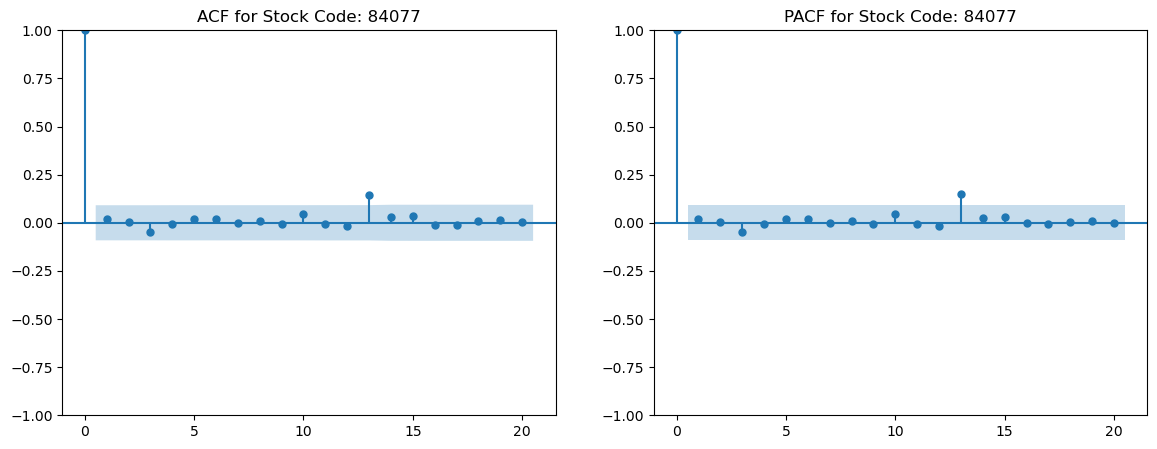

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

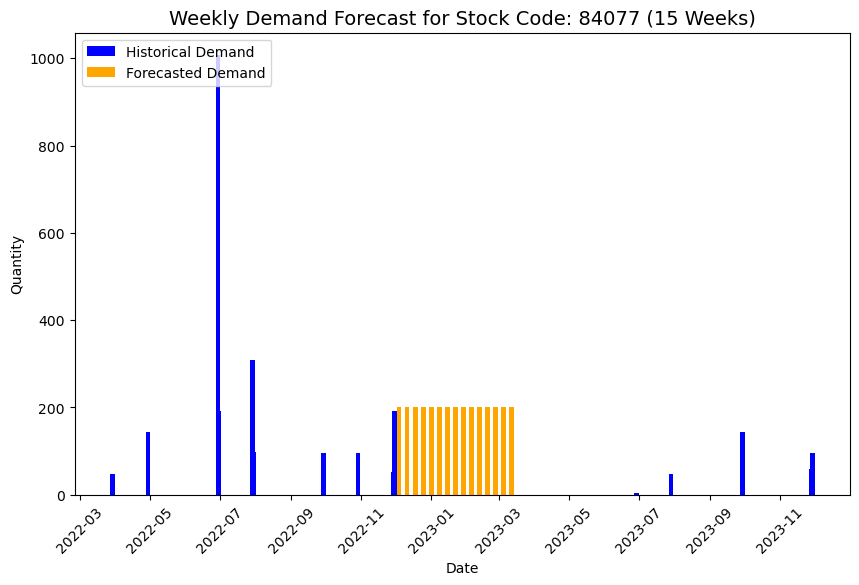

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


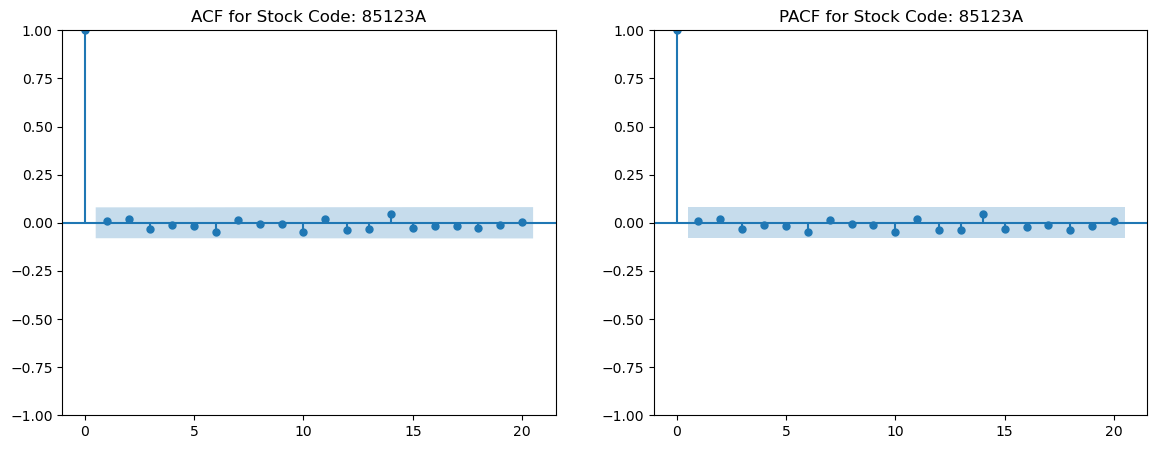

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

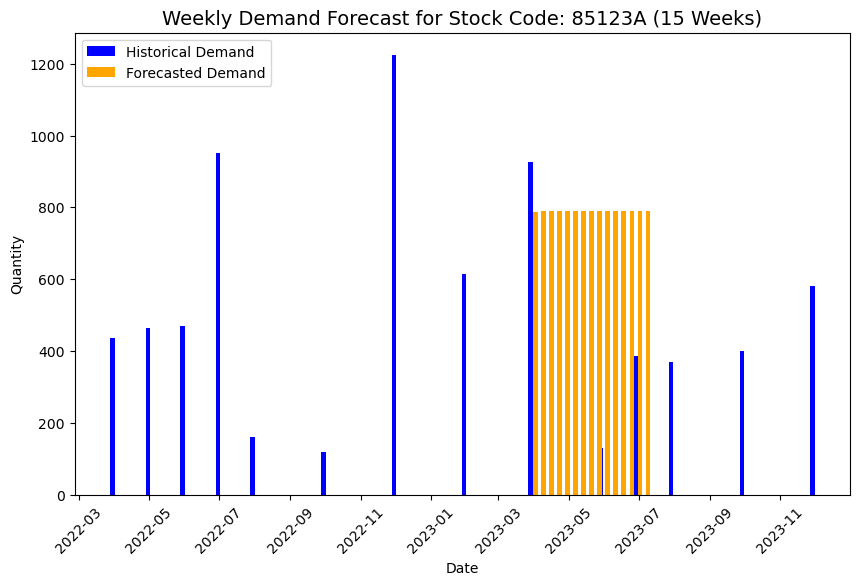

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


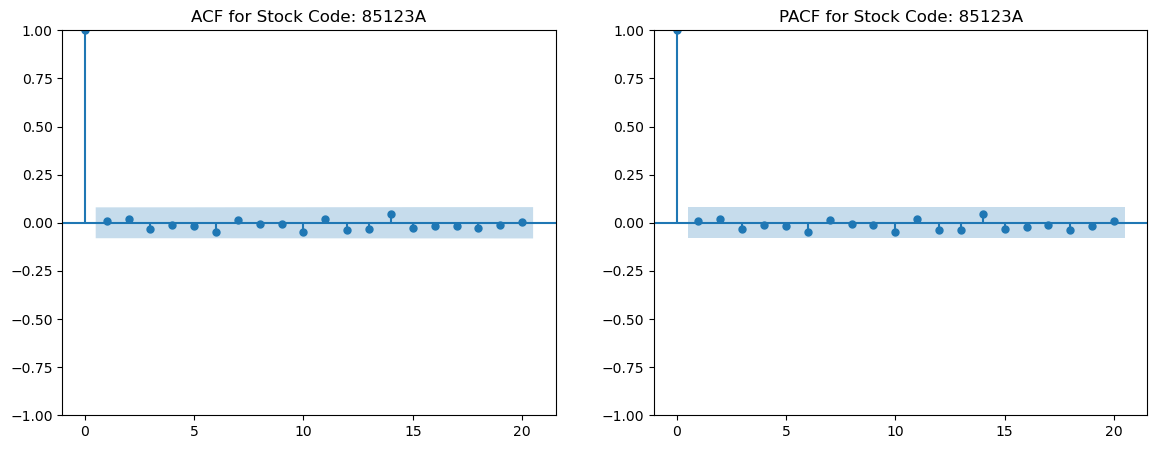

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

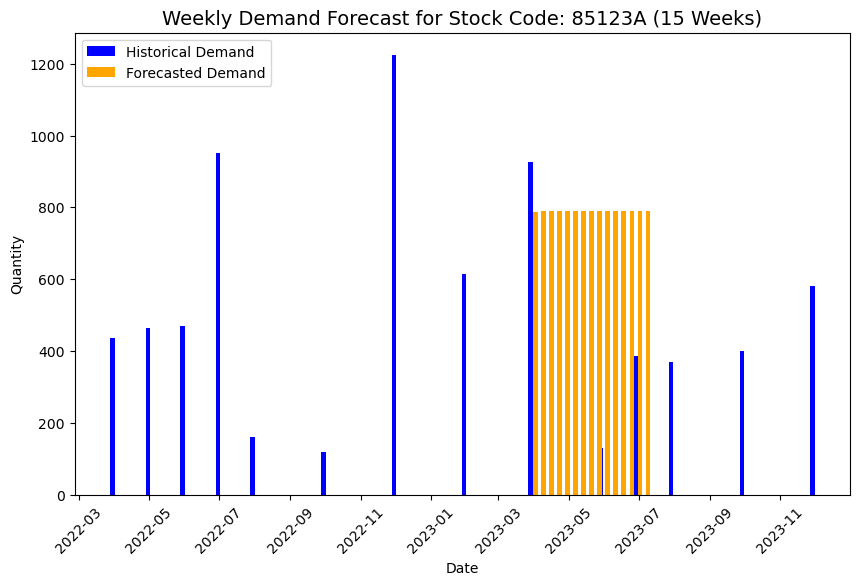

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


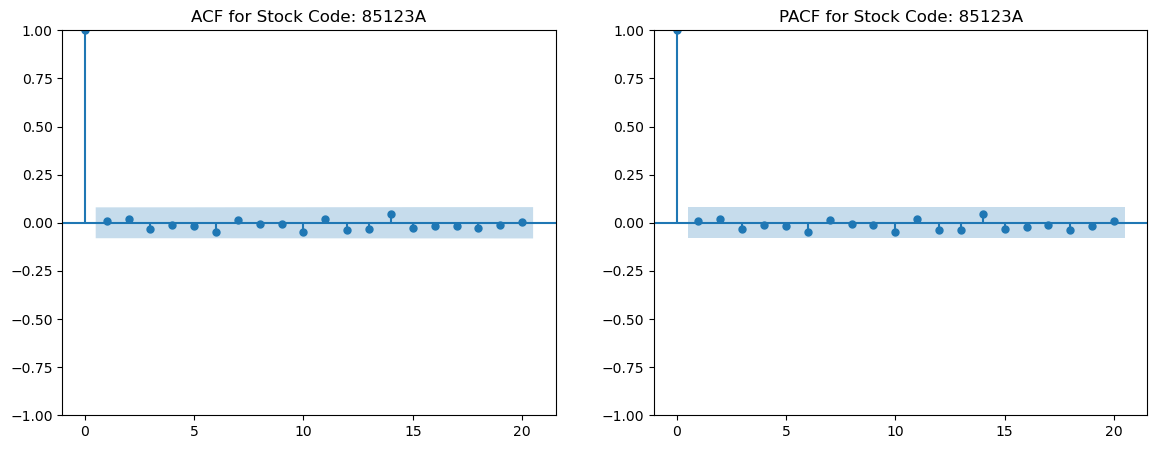

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

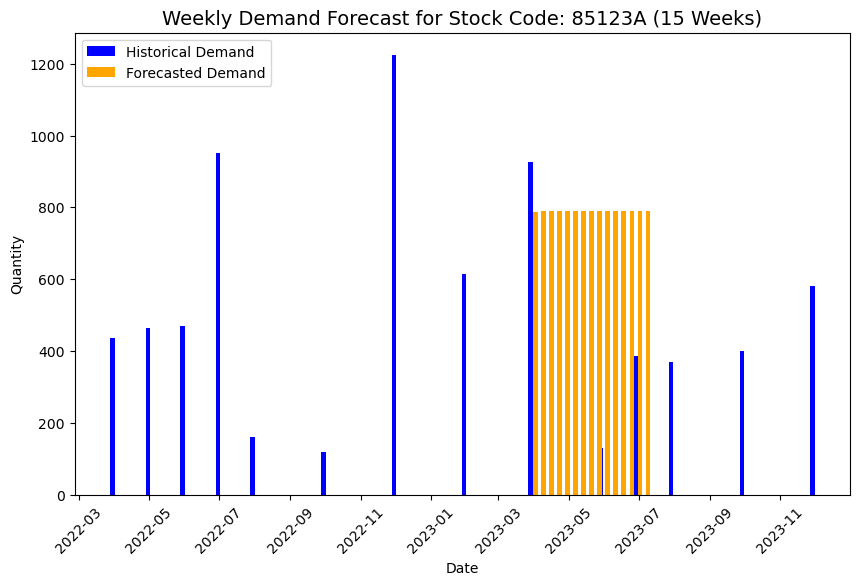

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


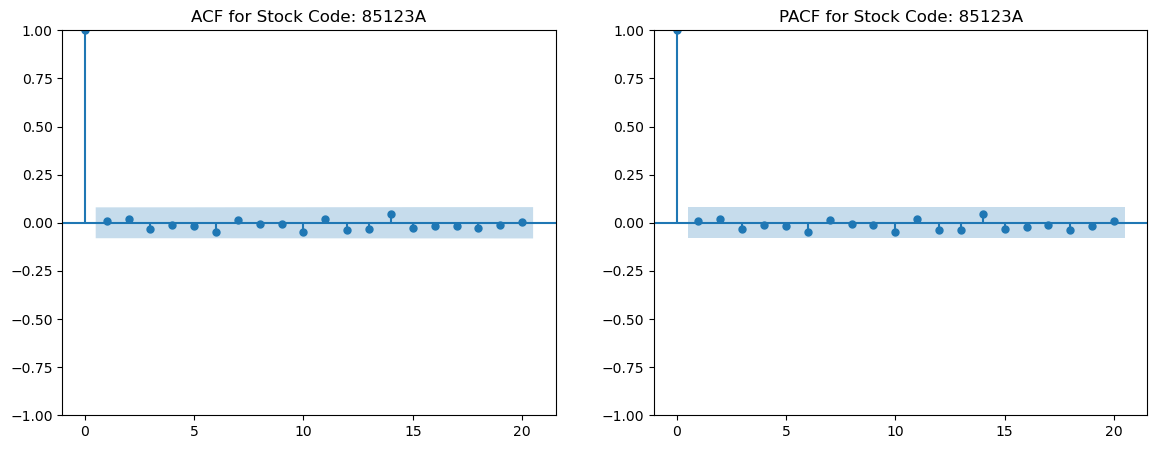

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

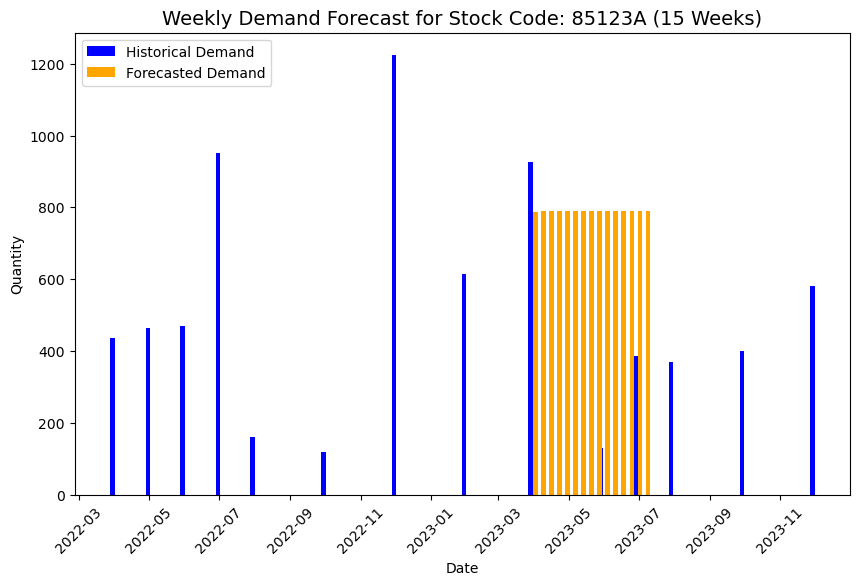

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


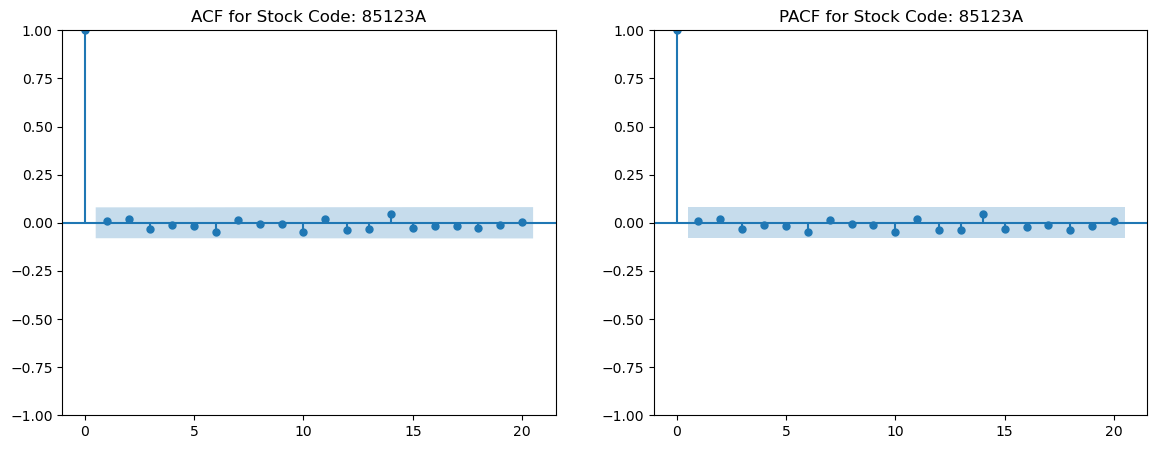

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

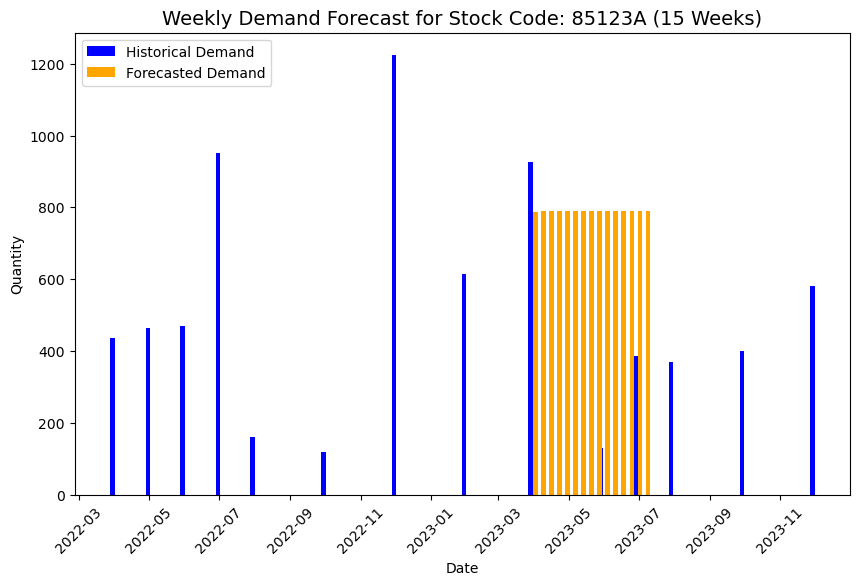

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


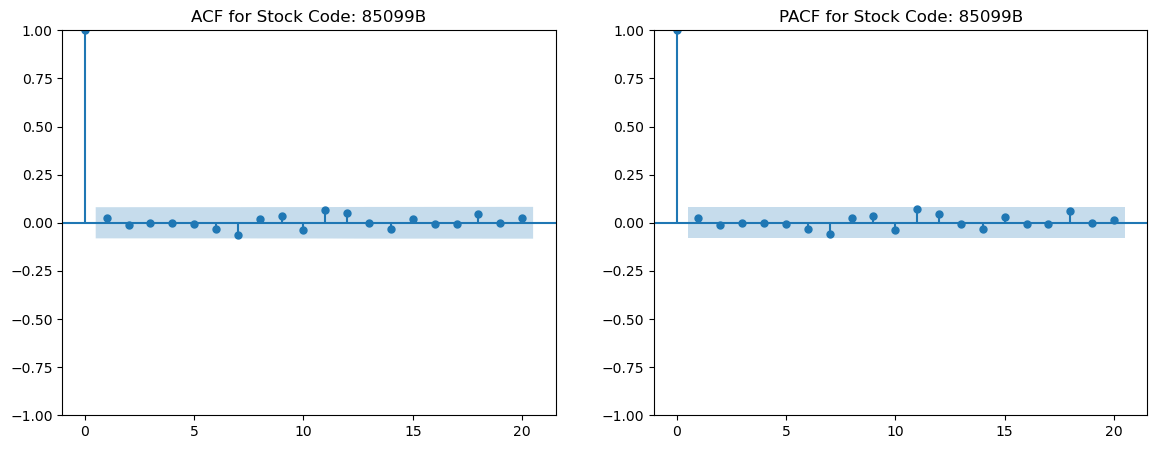

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

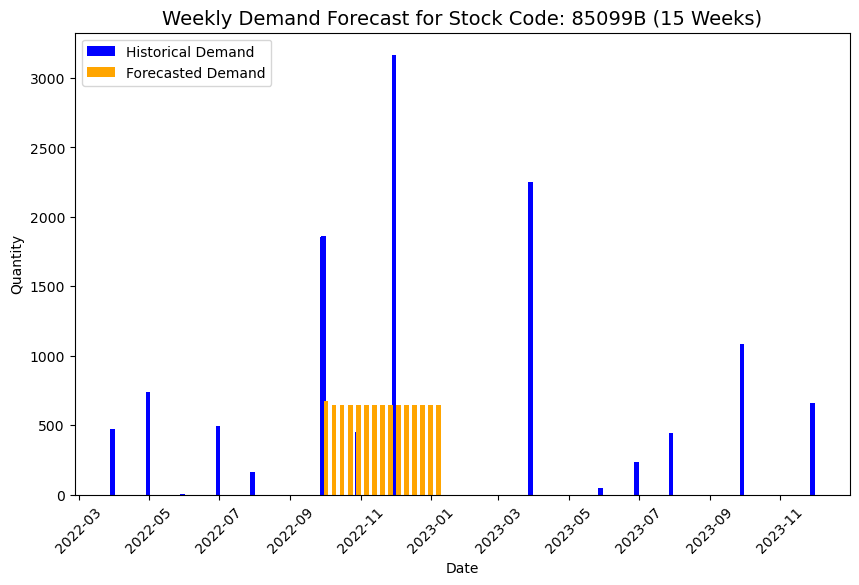

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


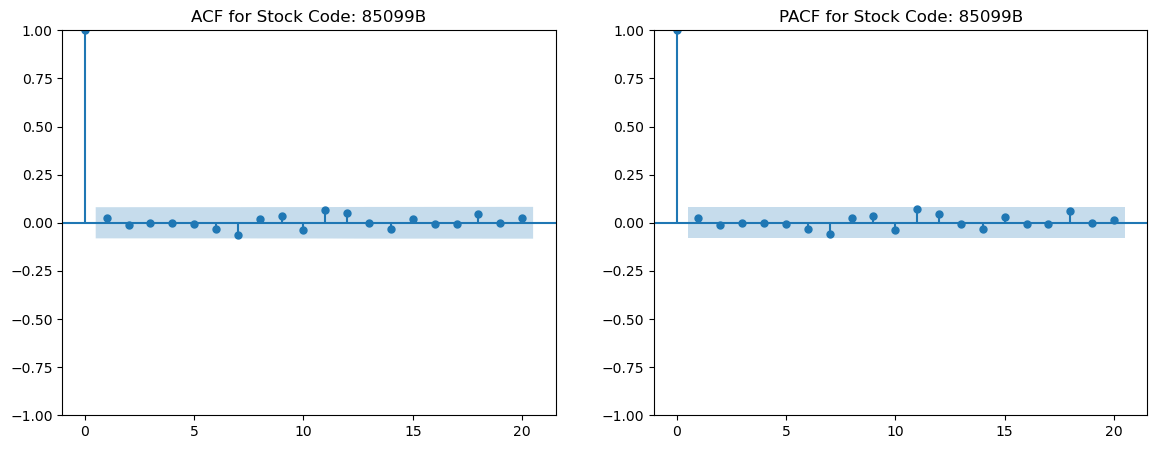

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

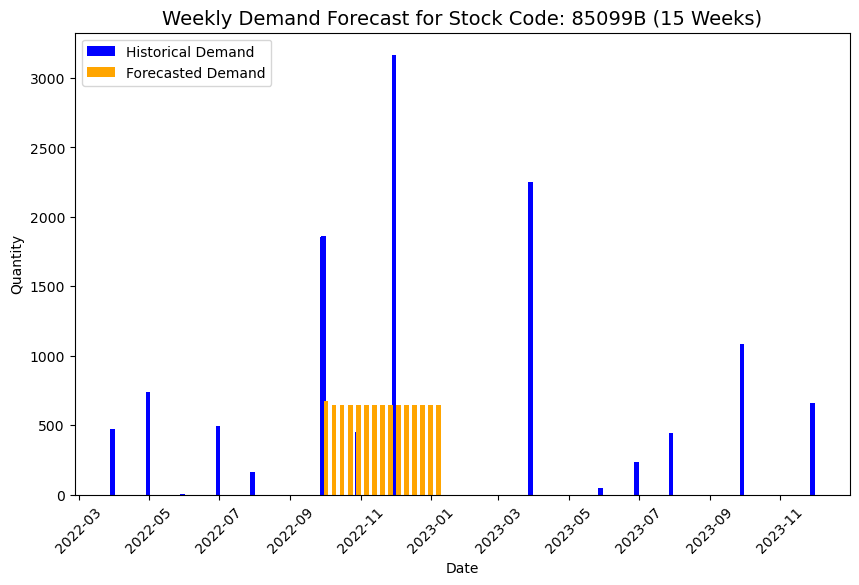

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


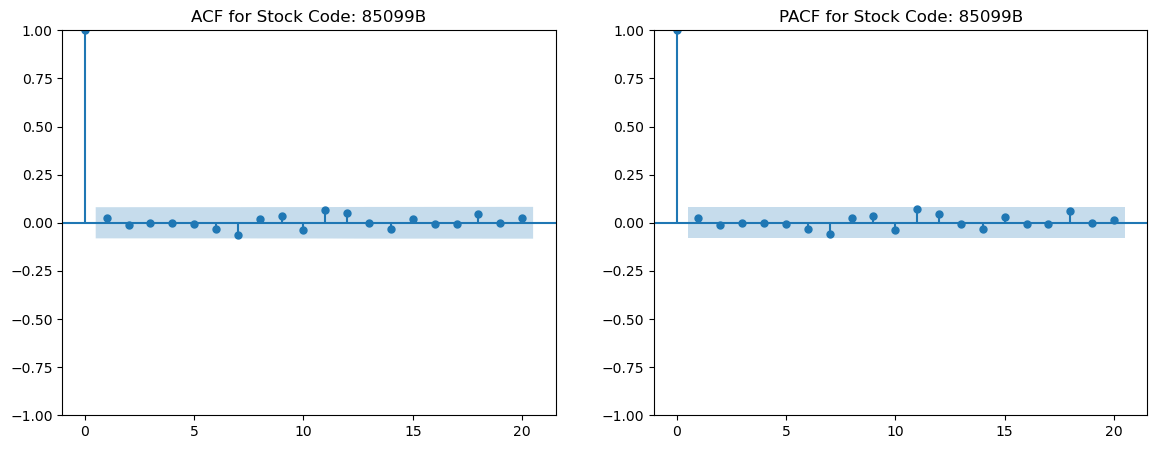

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

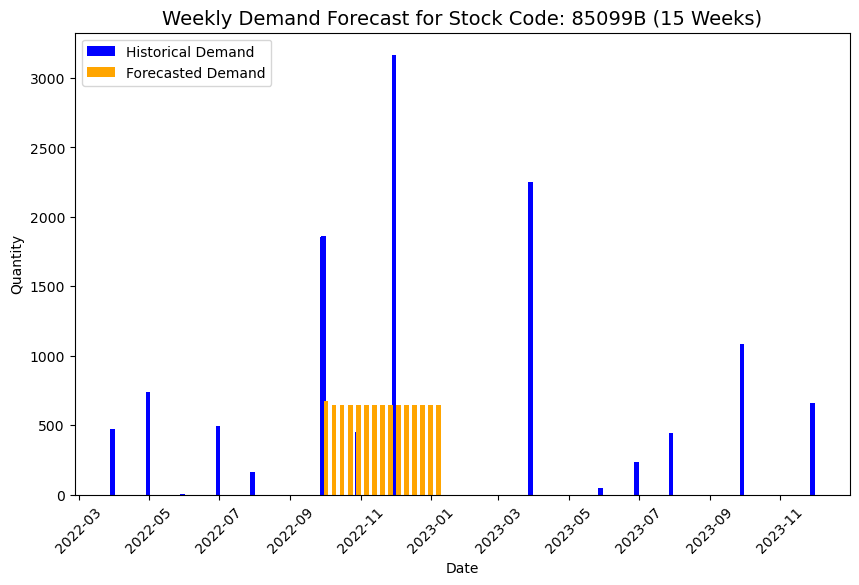

C:\Users\prabh\AppData\Local\Temp\ipykernel_5984\300221956.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  product_data.index = pd.to_datetime(product_data.index)


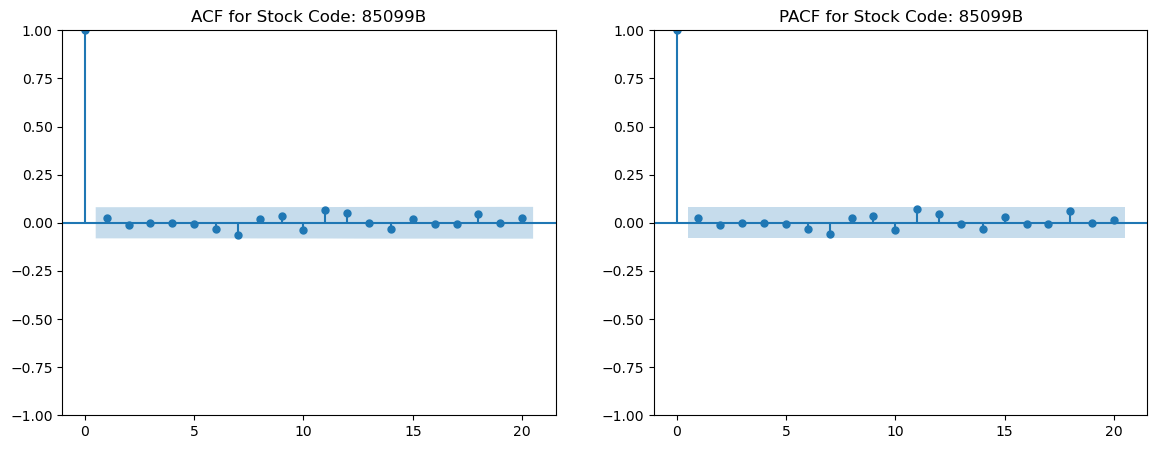

c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\prabh\anaconda3\Lib\site-

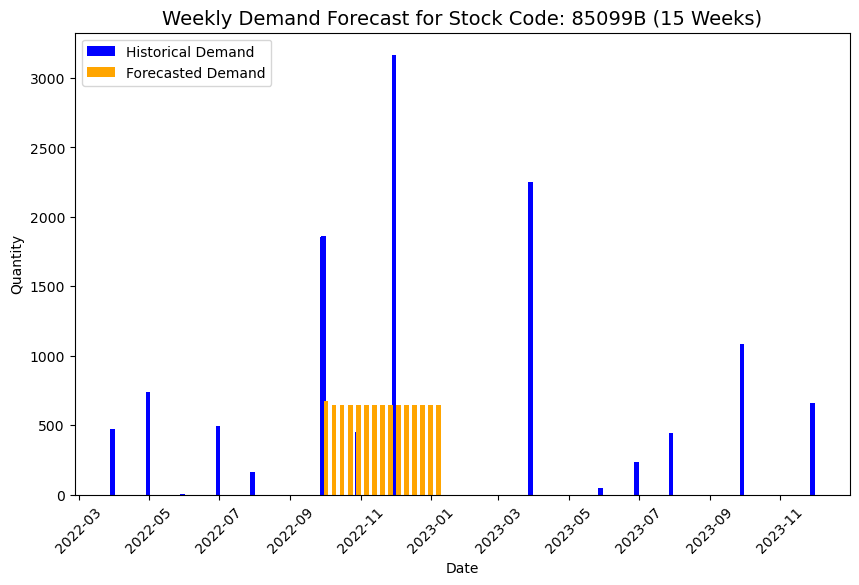

  Product         MAE        RMSE
0   84077  181.000277  287.433831
1  85123A  348.712754  425.652352
2  85123A  348.712754  425.652352
3  85123A  348.712754  425.652352
4  85123A  348.712754  425.652352
5  85123A  348.712754  425.652352
6  85099B  412.609258  447.381598
7  85099B  412.609258  447.381598
8  85099B  412.609258  447.381598
9  85099B  412.609258  447.381598


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming 'top_10_products' is a DataFrame containing 'StockCode' of the top products
# And 'complete_data' is the full dataset with 'StockCode', 'TransactionDate', and 'Quantity'

# Forecasting horizon
forecast_steps = 15  # 15 weeks

# Store metrics for evaluation
evaluation_metrics = pd.DataFrame(columns=['Product', 'MAE', 'RMSE'])

# Loop through each product in the top 10 and forecast
for idx, product in enumerate(top_10_products['StockCode'], 1):
    # Prepare the time series data for the current product
    product_data = complete_data[complete_data['StockCode'] == product].groupby('InvoiceDate')['Quantity'].sum()
    product_data.index = pd.to_datetime(product_data.index)
    
    # Split the data into training and testing sets
    train = product_data[:-forecast_steps]  # All data except the last 15 weeks
    test = product_data[-forecast_steps:]  # Last 15 weeks for testing

    # Plot ACF and PACF to analyze lags and seasonality
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(train, lags=20, ax=ax1, title=f'ACF for Stock Code: {product}')
    plot_pacf(train, lags=20, ax=ax2, title=f'PACF for Stock Code: {product}')
    plt.show()

    # Fit ARIMA model based on visual analysis of ACF/PACF (can be adjusted)
    model = sm.tsa.ARIMA(train, order=(1, 1, 1))  # Adjust order based on ACF/PACF
    model_fit = model.fit()

    # Forecast the next 15 weeks
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    # Store evaluation metrics for this product
    evaluation_metrics = evaluation_metrics.append({'Product': product, 'MAE': mae, 'RMSE': rmse}, ignore_index=True)
    
    # Plot historical data and forecast in a histogram
    plt.figure(figsize=(10, 6))
    
    # Plot historical demand as a histogram
    plt.bar(train.index[-15:], train[-15:], label='Historical Demand', color='blue', width=4)

    # Create index for the forecasted dates
    forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='W')
    
    # Plot forecast data as a separate histogram
    plt.bar(forecast_index, forecast, label='Forecasted Demand', color='orange', width=4)

    # Adding titles and labels
    plt.title(f'Weekly Demand Forecast for Stock Code: {product} (15 Weeks)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.show()

# Display evaluation metrics
print(evaluation_metrics)
